# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
from jupyterthemes import jtplot
jtplot.style()

In [4]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

c:\users\indez\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\indez\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\indez\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\users\in

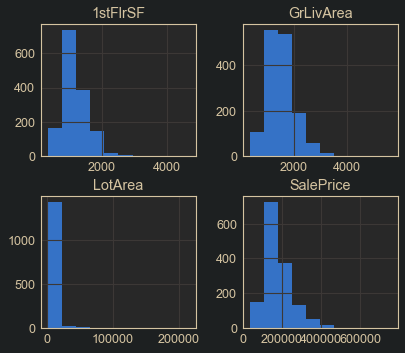

In [5]:
ames[continuous].hist();

BldgType


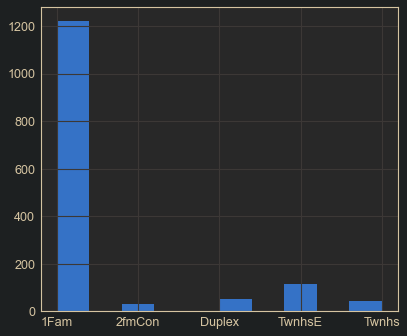

KitchenQual


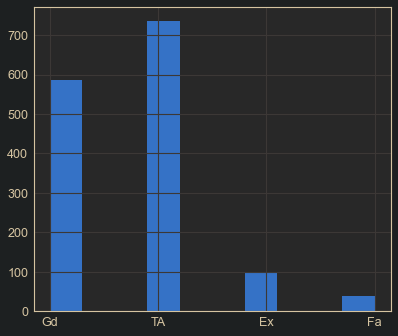

SaleType


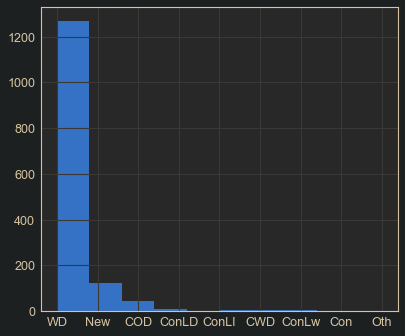

MSZoning


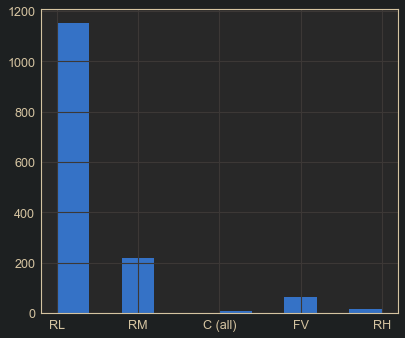

Street


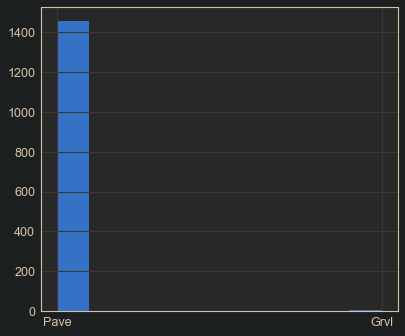

Neighborhood


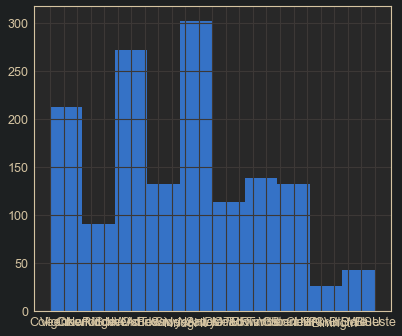

In [6]:
for var in categoricals:
    print(var)
    ames[var].hist()
    plt.show()

In [7]:
## code here
# Log transforming continuous variables
ames_cont = ames[continuous]
log_names = [f'{column}_log' for column in ames_cont.columns]
ames_log = np.log(ames_cont)
ames_log.columns = log_names

# Normalize continuous variables
for col in ames_log.columns:
    ames_log[col] = (ames_log[col] - ames_log[col].mean()) / ames_log[col].std()
    
# Get dummies for categorical variables
ames_dummies = pd.get_dummies(ames[categoricals], 
                              prefix=categoricals, 
                              drop_first=True
                             )

data = pd.concat([ames_log, ames_dummies], axis=1)

X = data.drop(columns=['SalePrice_log'])
y = data['SalePrice_log']

crossval = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossval))

# Get baseline R2
print("Baseline R squared:", baseline)

Baseline R squared: 0.8174636844561984


## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [8]:
from itertools import combinations

In [9]:
# code to find top interactions by R^2 value here
scores = {}
for combo in combinations(data.drop(columns=['SalePrice_log']).columns, 2):
    data_new = data.copy()
    data_new[f'{combo[0]}x{combo[1]}'] = data_new[combo[0]] * data_new[combo[1]]
    X = data_new.drop(columns=['SalePrice_log'])
    y = data_new['SalePrice_log']
    score = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossval))
    scores[combo] = score

In [10]:
from operator import itemgetter
largest = dict(sorted(scores.items(), key = itemgetter(1), reverse = True)[:3])
print(largest)

{('BldgType_Duplex', 'Street_Pave'): 0.8196563892558343, ('LotArea_log', 'Neighborhood_Mitchel'): 0.8196447680686683, ('GrLivArea_log', 'BldgType_Duplex'): 0.8196201279691963}


It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

(52,)


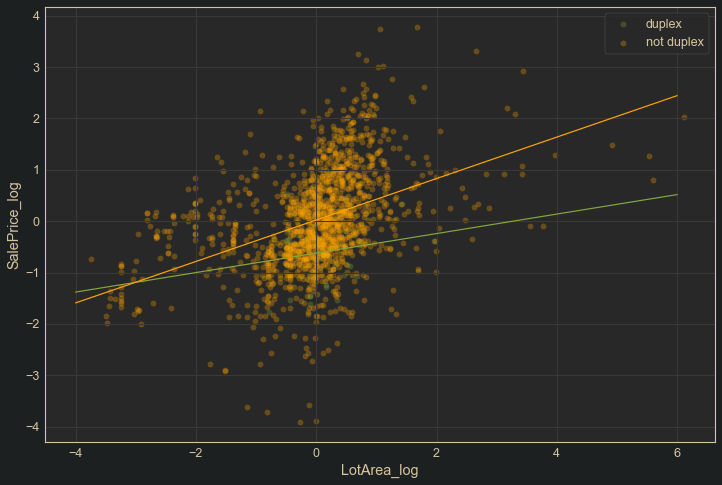

In [11]:
# Visualization code here
duplex = data[data['BldgType_Duplex'] == 1]
not_duplex = data[data['BldgType_Duplex'] == 0]

X1 = duplex.drop(columns=['SalePrice_log'])['LotArea_log']
X2 = not_duplex.drop(columns=['SalePrice_log'])['LotArea_log']
y1 = duplex['SalePrice_log']
y2 = not_duplex['SalePrice_log']

print(X1.shape)

reg1 = LinearRegression().fit(X1.values.reshape(-1, 1), y1)
reg2 = LinearRegression().fit(X2.values.reshape(-1, 1), y2)

pred1 = reg1.predict(X1.values.reshape(-1, 1))
pred2 = reg2.predict(X2.values.reshape(-1, 1))

plt.figure(figsize=(12,8))
plt.scatter(X1, y1, color='g', alpha=0.3, label='duplex')
plt.scatter(X2, y2, color='orange', alpha=0.3, label='not duplex')
xs = np.linspace(-4, 6).reshape(-1, 1)
plt.plot(xs, reg1.predict(xs), color='g')
plt.plot(xs, reg2.predict(xs), color='orange')
plt.xlabel('LotArea_log')
plt.ylabel('SalePrice_log')
plt.legend()
plt.show()

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [12]:
# code here
new_data = data.copy()
for key in largest.keys():
    new_data[str(key)] = new_data[key[0]] * new_data[key[1]]
    
X = new_data.drop(columns=['SalePrice_log'])
y = new_data['SalePrice_log']

new_model = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossval))

new_model

0.8225916600084799

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [13]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

results.summary()

c:\users\indez\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     151.1
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:59:06   Log-Likelihood:                -720.35
No. Observations:                1460   AIC:                             1543.
Df Residuals:                    1409   BIC:                             1812.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -0.4531      0.280     -1.620      0.106      -1.002       0.096
LotArea_log                                 0.1181      0.019      6.230      0.000       0.081       0.155
1stFlrSF_log                                0.1361      0.016      8.607      0.000       0.105       0.167
GrLivArea_log                               0.3858      0.016     24.564      0.000       0.355       0.417
BldgType_2fmCon                            -0.1531      0.078     -1.959      0.050      -0.306       0.000
BldgType_Duplex                             0.2869      0.382      0.751      0.453      -0.463       1.037
BldgType_Twnhs                             -0.1278      0.092     -1.392      0.164      -0.308       0.052
BldgType_TwnhsE                            -0.0456      0.059     -0.772      0.440      -0.161       0.070
KitchenQual_Fa                             -0.9798      0.088    -11.188      0.000      -1.152      -0.808
KitchenQual_Gd                             -0.3717      0.050     -7.485      0.000      -0.469      -0.274
KitchenQual_TA                             -0.6533      0.055    -11.937      0.000      -0.761      -0.546
SaleType_CWD                                0.2186      0.213      1.027      0.305      -0.199       0.636
SaleType_Con                                0.5743      0.301      1.909      0.056      -0.016       1.164
SaleType_ConLD                              0.3357      0.154      2.181      0.029       0.034       0.638
SaleType_ConLI                              0.0505      0.193      0.261      0.794      -0.328       0.429
SaleType_ConLw                              0.0159      0.194      0.082      0.935      -0.364       0.396
SaleType_New                                0.2882      0.078      3.692      0.000       0.135       0.441
SaleType_Oth                                0.1165      0.243      0.480      0.631      -0.360       0.593
SaleType_WD                                 0.1692      0.065      2.617      0.009       0.042       0.296
MSZoning_FV                                 1.0075      0.193      5.210      0.000       0.628       1.387
MSZoning_RH                                 0.8503      0.195      4.365      0.000       0.468       1.232
MSZoning_RL                                 0.9229      0.163      5.654      0.000       0.603       1.243
MSZoning_RM                                 1.0131      0.153      6.619      0.000       0.713       1.313
Street_Pave                                 0.2041      0.222      0.920      0.358      -0.231       0.639
Neighborhood_Blueste                        0.0731      0.315      0.232      0.816      -0.544       0.690
Neighborhood_BrDale                        -0.4402      0.1

What is your conclusion here?

In [14]:
# formulate your conclusion
# Two out of the three interactions is significant, at least with the features as they are now
# I would probably take out some of the more insignificant predictors first and see how these
# scores were affected before removing any of the added interactions.
# The R2 has increased as a result of adding the interactions.
X = data.drop(columns=['SalePrice_log'])
y = data['SalePrice_log']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     156.5
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:01:42   Log-Likelihood:                -738.14
No. Observations:                1460   AIC:                             1572.
Df Residuals:                    1412   BIC:                             1826.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1317      0.263     -0.500      0.617      -0.648       0.385
LotArea_log              0.1033      0.019      5.475      0.000       0.066       0.140
1stFlrSF_log             0.1371      0.016      8.584      0.000       0.106       0.168
GrLivArea_log            0.3768      0.016     24.114      0.000       0.346       0.407
BldgType_2fmCon         -0.1715      0.079     -2.173      0.030      -0.326      -0.017
BldgType_Duplex         -0.4203      0.062     -6.813      0.000      -0.541      -0.299
BldgType_Twnhs          -0.1403      0.093     -1.513      0.130      -0.322       0.042
BldgType_TwnhsE         -0.0512      0.060     -0.858      0.391      -0.168       0.066
KitchenQual_Fa          -0.9999      0.088    -11.315      0.000      -1.173      -0.827
KitchenQual_Gd          -0.3820      0.050     -7.613      0.000      -0.480      -0.284
KitchenQual_TA          -0.6692      0.055    -12.111      0.000      -0.778      -0.561
SaleType_CWD             0.2285      0.215      1.061      0.289      -0.194       0.651
SaleType_Con             0.5861      0.304      1.927      0.054      -0.010       1.183
SaleType_ConLD           0.3151      0.155      2.029      0.043       0.010       0.620
SaleType_ConLI           0.0331      0.195      0.169      0.865      -0.350       0.416
SaleType_ConLw           0.0161      0.196      0.082      0.935      -0.368       0.400
SaleType_New             0.2999      0.079      3.803      0.000       0.145       0.455
SaleType_Oth             0.1178      0.245      0.480      0.631      -0.364       0.599
SaleType_WD              0.1748      0.065      2.676      0.008       0.047       0.303
MSZoning_FV              1.0666      0.193      5.526      0.000       0.688       1.445
MSZoning_RH              0.8768      0.194      4.512      0.000       0.496       1.258
MSZoning_RL              0.9961      0.162      6.151      0.000       0.678       1.314
MSZoning_RM              1.1023      0.152      7.264      0.000       0.805       1.400
Street_Pave             -0.2131      0.180     -1.182      0.237      -0.567       0.141
Neighborhood_Blueste     0.0529      0.318      0.167      0.868      -0.571       0.677
Neighborhood_BrDale     -0.4627      0.171     -2.711      0.007      -0.798      -0.128
Neighborhood_BrkSide    -0.6498      0.137     -4.735      0.000      -0.919      -0.381
Neighborhood_ClearCr    -0.2102      0.144     -1.456      0.146      -0.493       0.073
Neighborhood_CollgCr    -0.0761      0.119     -0.641      0.522      -0.309       0.157
Neighborhood_Crawfor    -0.0823      0.129     -0.638      0.523      -0.335       0.171
Neighborhood_Edwards    -0.7613      0.124     -6.143      0.000      -1.004      -0.518
Neighborhood_Gilbert    -0.0980      0.126     -0.777    

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.